In [1]:
import numpy as np
from numpy.matlib import repmat
import pandas as pd
import EEG_Decoder.eeg_decoder as eeg_decoder
import scipy.io as sio
import pingouin as pg
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # change svg font type from path to text
import seaborn as sns

from mne.filter import filter_data
from scipy.signal import hilbert, chirp

from utils import clean_behavior, setup_hyperplane_conds

import scipy.stats as sista
from scipy.stats import ttest_1samp, ttest_rel
from statsmodels.stats.multitest import multipletests

from collections import Counter, OrderedDict, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(2023)

OVERWRITE = False

CORRECT_ONLY = False  # gives the same results

subtitle = f'collinearityPreds_correctOnly-{CORRECT_ONLY}'

In [3]:
experiment_name = 'DATA/Preprocessed'
data_dir = f'../../{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*.csv')))

In [4]:
full_times = np.arange(-650, 1650, 2)
tois = np.arange(-250, 1250, 2)
times_bool = [1 if (t in tois) else 0 for t in full_times]

In [5]:
time_window = 25
time_step = 25
trial_bin_size = 15
n_splits = 1000
group_dict = OrderedDict([('1',[1]),('2',[2]),('3',[3]),('4',[4]),('5',[5]),('6',[6]),('7',[7]),('8',[8])])

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
xdata_dict = {}
alpha_dict = {}
behavior_dict = {}

for isub in range(exp.nsub):
    xdata,_ = exp.load_eeg(isub)
    xdata = np.squeeze(xdata[:,:,np.where(times_bool)]) # cut out pre-baseline & test timepoints
    
    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()
    
    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = clean_behavior(behavior, noArt_idx, isub)    
    assert len(behavior)==xdata.shape[0]
    
    # drop interruption trials for subs 4,5
    no_interruption_trials = (behavior.port_codes < 240).values
    behavior = behavior[no_interruption_trials].reset_index(drop=True)
    xdata = xdata[no_interruption_trials, :, :]
    
    # match nDots across loads
    behavior = behavior.query('total_nDots >= 24')
    xdata = xdata[behavior.index.values, :, :]
    behavior = behavior.reset_index(drop=True)
    
    
    xdata_dict[isub] = xdata
    behavior_dict[isub] = behavior

# training on SS1 broad and SS2 superset, testing on all other conditions

In [7]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.nanmean(a,0)
    sem = sista.sem(a,0, nan_policy='omit')
    upper,lower = mean + sem, mean - sem
    return mean, upper, lower

In [8]:
hyperplane_conds = {
    0: 'SS1 Narrow',
    1: 'SS1 Broad',
    2: 'SS2 Overlap Narrow',
    3: 'SS2 Overlap Broad',
    4: 'SS2 Superset Overlap',
    5: 'SS2 Partial Overlap',
    6: 'SS2 NoOverlap Mixed',
    7: 'SS2 NoOverlap Narrow',
    8: 'SS2 NoOverlap Broad'
}

cond_load_map = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1} # mapping the conditions to loads

colormap = {
    0: 'lightsalmon',
    1: 'skyblue',
    2: 'red',
    3: 'blue',
    4: 'purple',
    5: 'green',
    6: 'magenta',
    7: 'orange',
    8: 'aqua'
}

palette={hyperplane_conds[idx]: colormap[idx] for idx in range(9)}
palette

{'SS1 Narrow': 'lightsalmon',
 'SS1 Broad': 'skyblue',
 'SS2 Overlap Narrow': 'red',
 'SS2 Overlap Broad': 'blue',
 'SS2 Superset Overlap': 'purple',
 'SS2 Partial Overlap': 'green',
 'SS2 NoOverlap Mixed': 'magenta',
 'SS2 NoOverlap Narrow': 'orange',
 'SS2 NoOverlap Broad': 'aqua'}

In [9]:
clfr.confidence_scores = np.full((exp.nsub,len(wrangl.t),wrangl.n_splits,len(hyperplane_conds.keys())), np.nan)  # overwriting original setup

In [10]:
if OVERWRITE:
    for isub in range(exp.nsub):    
        
        xdata = xdata_dict[isub]
        behavior = setup_hyperplane_conds(behavior_dict[isub], separate_no_overlap=True)
        
        if CORRECT_ONLY:
            # subset to correct only
            corr_idx = behavior.query('ACC==1').index.values
            behavior = behavior.loc[corr_idx, :].reset_index(drop=True)
            xdata = xdata[corr_idx, :, :]
        
        # get labels
        ydata = behavior.hyperplane_conditions.values
        
        print(isub, Counter(ydata))
        
        for wrangl.ifold in range(wrangl.n_splits):
            xdata_binned, ydata_binned = wrangl.bin_trials(xdata, ydata)  # random binning on each iter
            
            test_mask = []
            for cond in [1, 4]:
                test_mask.append(np.random.choice(np.where(ydata_binned==cond)[0])) # test on 1 of each condition

            # add all of other hyperplane conditions to test
            test_mask += np.where(ydata_binned==0)[0].tolist() # SS 1 Narrow
            test_mask += np.where(ydata_binned==2)[0].tolist() # SS 2 Narrow Overlap
            test_mask += np.where(ydata_binned==3)[0].tolist() # SS 2 Broad Overlap
            test_mask += np.where(ydata_binned==5)[0].tolist() # SS 2 Partial Overlap
            test_mask += np.where(ydata_binned==6)[0].tolist() # SS 2 No Overlap, mixed
            test_mask += np.where(ydata_binned==7)[0].tolist() # SS 2 No Overlap, narrow
            test_mask += np.where(ydata_binned==8)[0].tolist() # SS 2 No Overlap, broad
            
            train_mask = np.ones(len(ydata_binned), dtype=bool)
            train_mask[test_mask] = False
            
            X_train_all = xdata_binned[train_mask]
            X_test_all = xdata_binned[test_mask]
            y_train = ydata_binned[train_mask]

            # balance training data to avoid bias
            diff = np.sum((y_train==1)) - np.sum((y_train==4))
            if diff != 0:
                if diff > 0:
                    drop_idx = np.random.choice(np.where(y_train==1)[0], diff, replace=False)
                if diff < 0:
                    drop_idx = np.random.choice(np.where(y_train==4)[0], diff, replace=False)

                mask = np.ones(len(y_train), dtype=bool)
                mask[drop_idx] = False
                X_train_all = X_train_all[mask]
                y_train = y_train[mask]

            # Set up test and shuffle, fit across time
            y_test = ydata_binned[test_mask]
            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                X_train, X_test = clfr.standardize(X_train, X_test)
                clfr.classifier.fit(X_train, np.vectorize(cond_load_map.get)(y_train))

                clfr.acc[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test)
                clfr.acc_shuff[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test_shuffle)

                # get confidence of classification for each trial bin
                confidence_scores = clfr.classifier.decision_function(X_test)
                for i in set(y_test):
                    clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold,int(i)] = np.mean(confidence_scores[y_test==i])



    interp = eeg_decoder.Interpreter(clfr, subtitle = subtitle)
    interp.save_results(timestamp=False)

# Plot distances across time

In [11]:
interp = eeg_decoder.Interpreter()
interp.load_results(subtitle)

mean_scores = np.mean(interp.confidence_scores,2)

In [12]:
# Plot confidence of classifier, which is proportional to distance from hyperplane.
stim_lower,stim_upper = -4.3,3
stim_time = [0,250]

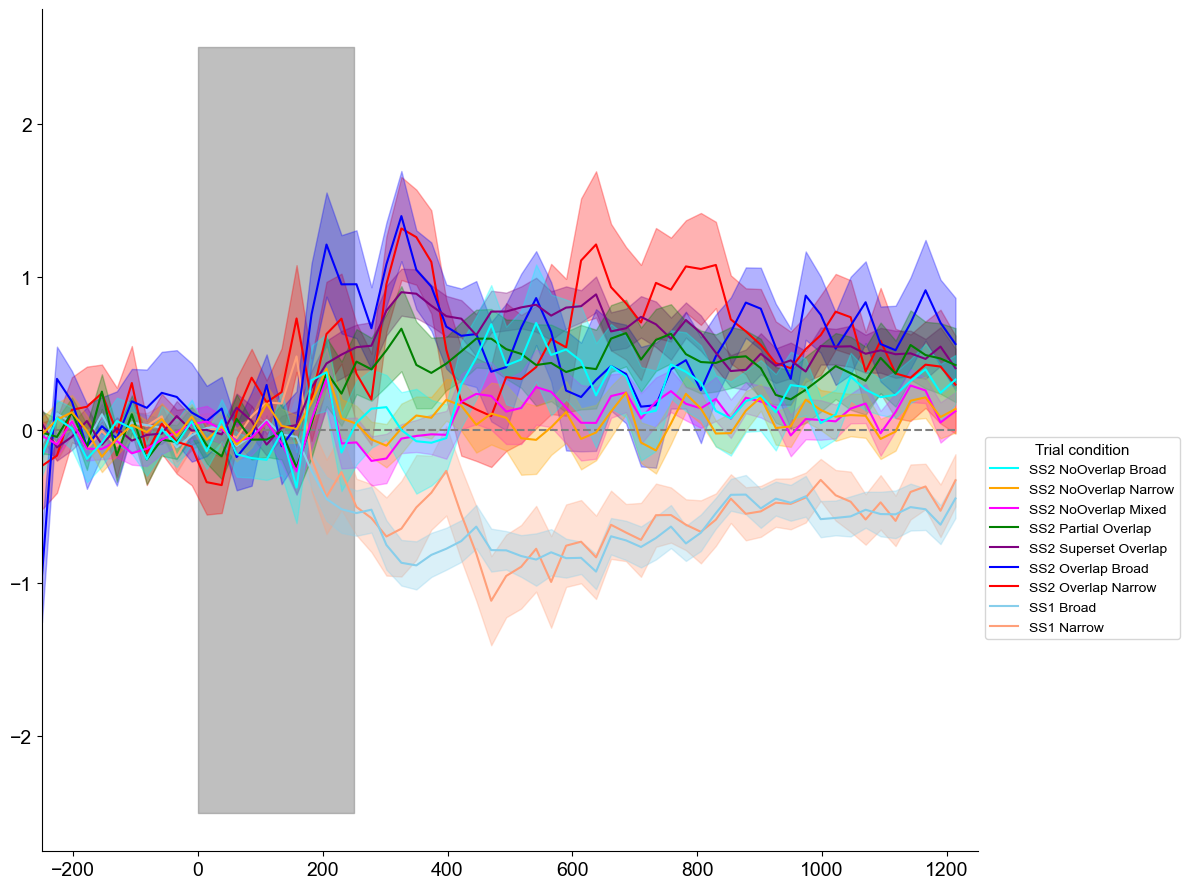

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.fill_between(stim_time,[-2.5,-2.5],[2.5,2.5],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')

for idx in range(mean_scores.shape[2]):
    scores = mean_scores[:,:,idx]
    
    med, upper, lower = get_plot_line(scores)
    ax.plot(interp.t,med,colormap[idx],label = hyperplane_conds[idx])
    ax.fill_between(interp.t,upper,lower, color=colormap[idx],alpha=.3)

    

handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles[::-1], labels[::-1], title='Trial condition',fontsize=10, bbox_to_anchor=(1, .5))
plt.setp(leg.get_title(),fontsize=11)

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=14)
_ = plt.setp(ax.get_yticklabels(), fontsize=14)

_ = plt.xlim(-250,1250)
plt.tight_layout()
plt.show()
plt.close()

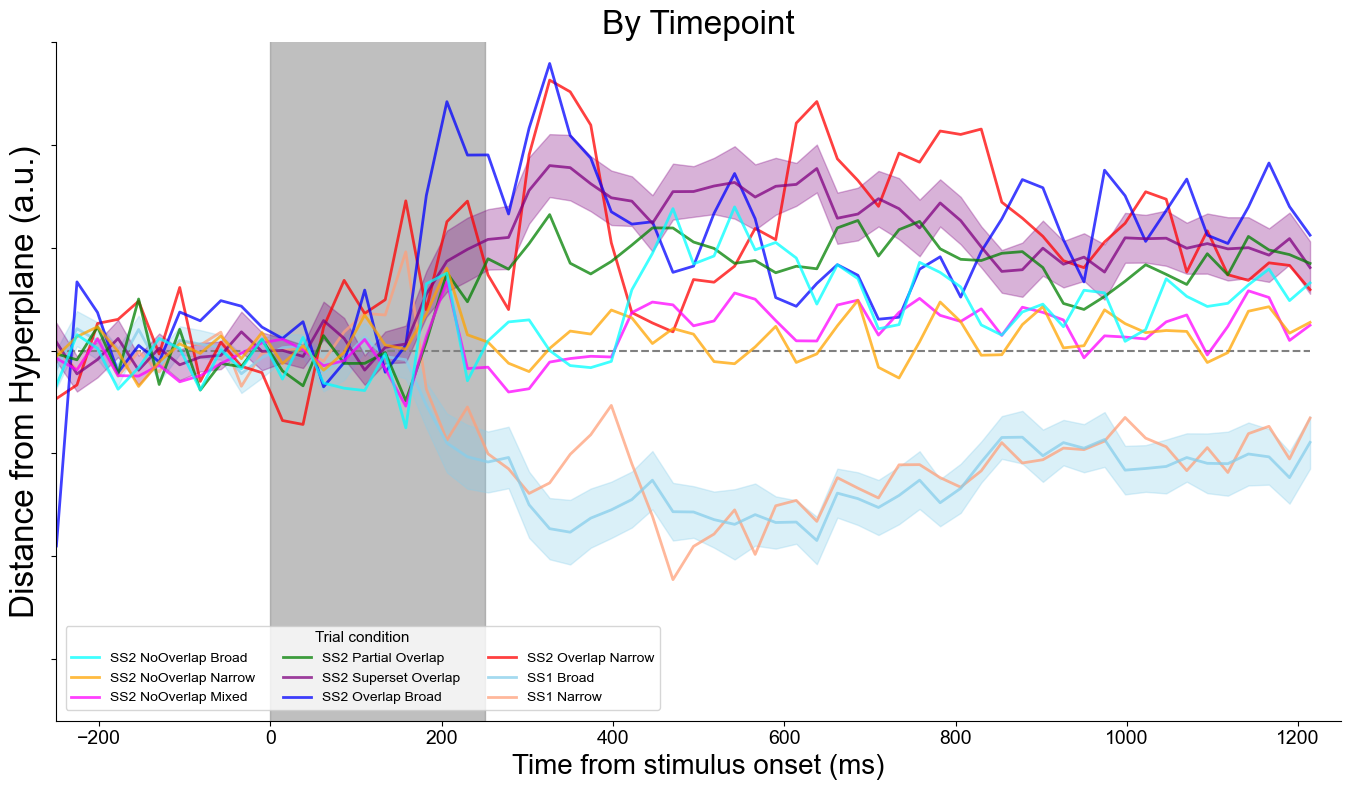

In [28]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

ax.fill_between(stim_time,[-2.5,-2.5],[2.5,2.5],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')

for idx in range(mean_scores.shape[2]):
    scores = mean_scores[:,:,idx]
    
    med, upper, lower = get_plot_line(scores)
    ax.plot(interp.t,med,colormap[idx],label = hyperplane_conds[idx], alpha=.75, linewidth=2)
    if idx in [1, 4]:
        ax.fill_between(interp.t,upper,lower, color=colormap[idx],alpha=.3)
    


handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles[::-1], labels[::-1], title='Trial condition',fontsize=10, ncol=3, bbox_to_anchor=(.475, .15))
plt.setp(leg.get_title(),fontsize=11)

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=14)
_ = plt.setp(ax.get_yticklabels(), fontsize=14)

ax.set_ylabel('Distance from Hyperplane (a.u.)', fontsize=24)
# ax.text(0.25, .98, 'Stim', transform=ax.transAxes, fontsize=20,
#                 verticalalignment='top', color='white')
plt.xlabel('Time from stimulus onset (ms)', fontsize=20)

_ = plt.xlim(-250,1250)
_ = plt.ylim(-1.8,1.5)
ax.set_yticklabels([])
plt.title('By Timepoint', fontsize=24)
plt.tight_layout()
plt.savefig('RawFigures/DistanceFromHyperplane_SS1BroadvSS2Superset_heldOutSuperimposed.svg')
plt.show()
plt.close()

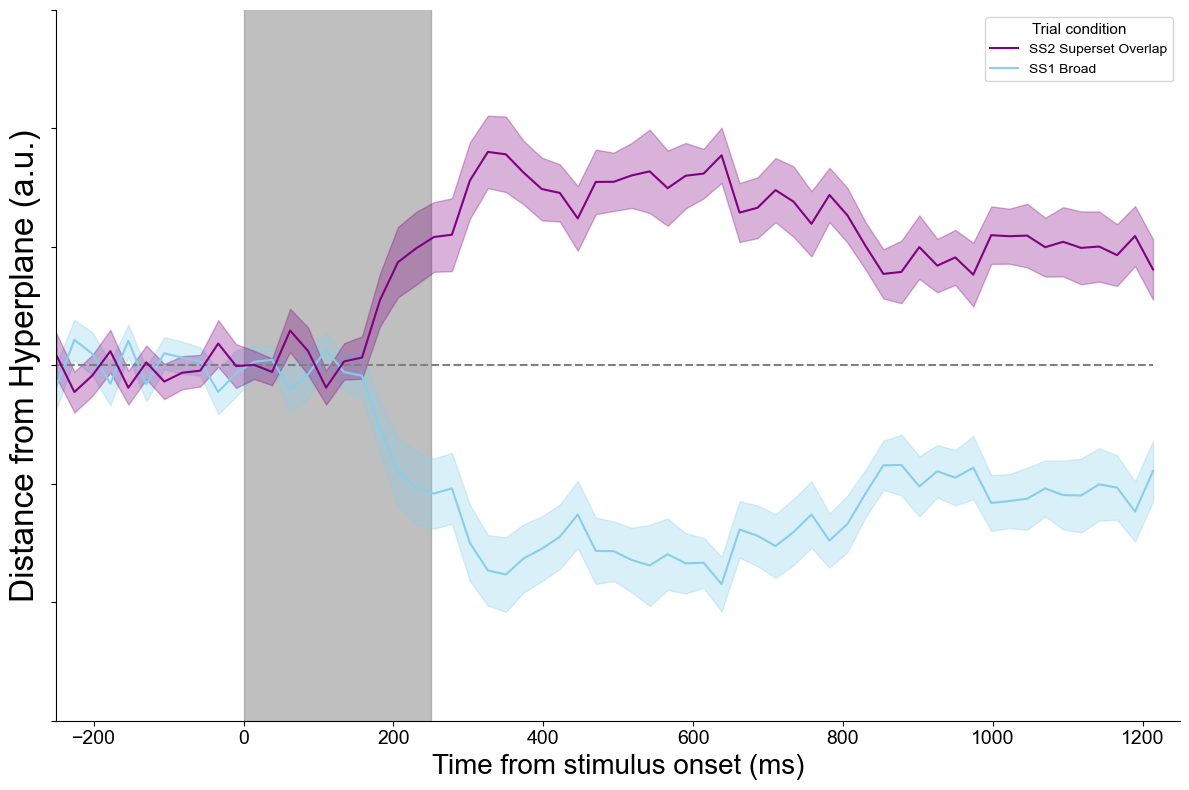

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.fill_between(stim_time,[-2.5,-2.5],[2.5,2.5],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')

for idx in [1, 4]:
    scores = mean_scores[:,:,idx]
    
    med, upper, lower = get_plot_line(scores)
    ax.plot(interp.t,med,colormap[idx],label = hyperplane_conds[idx])
    ax.fill_between(interp.t,upper,lower, color=colormap[idx],alpha=.3)
    

handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles[::-1], labels[::-1], title='Trial condition',fontsize=10,loc = 'upper right')
plt.setp(leg.get_title(),fontsize=11)

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=14)
_ = plt.setp(ax.get_yticklabels(), fontsize=14)

ax.set_ylabel('Distance from Hyperplane (a.u.)', fontsize=24)
# ax.text(0.25, .98, 'Stim', transform=ax.transAxes, fontsize=20,
#                 verticalalignment='top', color='white')
plt.xlabel('Time from stimulus onset (ms)', fontsize=20)

_ = plt.xlim(-250,1250)
_ = plt.ylim(-1.5,1.5)
ax.set_yticklabels([])
plt.tight_layout()
plt.savefig('RawFigures/DistanceFromHyperplane_SS1BroadvSS2Superset.svg')
plt.show()
plt.close()

# Average distance during delay period

In [ ]:
palette

{'SS1 Narrow': 'lightsalmon',
 'SS1 Broad': 'skyblue',
 'SS2 Overlap Narrow': 'red',
 'SS2 Overlap Broad': 'blue',
 'SS2 Superset Overlap': 'purple',
 'SS2 Partial Overlap': 'green',
 'SS2 NoOverlap Mixed': 'magenta',
 'SS2 NoOverlap Narrow': 'orange',
 'SS2 NoOverlap Broad': 'aqua'}

In [ ]:
def get_delay_distances(mean_scores, interp, hyperplane_conds, delay_start=250, delay_end=1150):
    
    delay_distances = pd.DataFrame()
    for idx in range(mean_scores.shape[2]):
        sub_scores = mean_scores[:,(interp.t > delay_start) & (interp.t <= delay_end),idx].mean(1)
        
        cond_df = pd.DataFrame([np.arange(len(sub_scores)), sub_scores], index=['subid', 'mean_delay_distance']).T
        cond_df['Condition'] = hyperplane_conds[idx]
        
        delay_distances = pd.concat([delay_distances, cond_df])
        
    return delay_distances.reset_index(drop=True)


def plot_and_test_mean_delays(delay_distances, figname=None):
    fig, axes = plt.subplots(1,2, figsize=(10, 6),sharey=True, gridspec_kw={'width_ratios': [1, 3]})

    # left hand side - train conditions
    train_conds = ['SS1 Broad', 'SS2 Superset Overlap']
    ax = sns.barplot(x='Condition', y='mean_delay_distance', data=delay_distances, palette=palette, order=train_conds, ax=axes[0])
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 20, ha='right')
    _ = ax.axhline(0, color='k', linestyle='--')

    print('AGAINST 0:')
    for idx, cond in enumerate(train_conds):
        print(cond)
        t_res = pg.ttest(x=delay_distances.query(f'Condition=="{cond}"').mean_delay_distance.values, y=0)
        # get p value, t value
        t = t_res['T'].values[0]
        p = t_res['p-val'].values[0]
        print(t_res)
        
        if p < .05:
            _ = ax.scatter([idx], [1.25*np.sign(t)],
                            marker = '*', s=10, c = 'k')

    ax.set_ylabel('Mean Distance from Hyperplane (a.u.)', fontsize='16')
    _ = ax.set_xlabel('')
    _ = ax.set_title('Training Conditions', fontsize=14)

    # right hand side - test conditions
    test_conds = ['SS1 Narrow', 'SS2 Overlap Narrow', 'SS2 Overlap Broad', 'SS2 Partial Overlap', 'SS2 NoOverlap Narrow', 'SS2 NoOverlap Broad', 'SS2 NoOverlap Mixed']
    ax = sns.barplot(x='Condition', y='mean_delay_distance', data=delay_distances, palette=palette, order=test_conds, ax=axes[1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 20, ha='right')
    _ = ax.axhline(0, color='k', linestyle='--')

    print('DIFFERENT FROM SS1BROAD:')
    for idx, cond in enumerate(test_conds):
        t_res = pg.pairwise_ttests(dv='mean_delay_distance', within='Condition', subject='subid', data=delay_distances[delay_distances.Condition.isin([cond, train_conds[0]])], effsize='cohen')
        # get p value, t value
        t = t_res['T'].values[0]
        p = t_res['p-unc'].values[0]
        print(t_res)

        if p < .05:
            _ = ax.scatter([idx], [1.25],
                            marker = '*', s=10, c = 'k')
            
    print('DIFFERENT FROM SS2SUPERSET:')
    for idx, cond in enumerate(test_conds):
        t_res = pg.pairwise_ttests(dv='mean_delay_distance', within='Condition', subject='subid', data=delay_distances[delay_distances.Condition.isin([cond, train_conds[1]])], effsize='cohen')
        # get p value, t value
        t = t_res['T'].values[0]
        p = t_res['p-unc'].values[0]
        print(t_res)

        if p < .05:
            _ = ax.scatter([idx], [-1.25],
                            marker = '*', s=10, c = 'k')

    ax.set_yticks([])
    _ = ax.set_ylabel('')
    _ = ax.set_xlabel('')
    _ = ax.set_title('Test Conditions vs Training Conditions', fontsize=14)

    _ = plt.tight_layout()
    if figname is not None:
        plt.savefig(f'RawFigures/{figname}')
    plt.show()
    plt.close()

AGAINST 0:
SS1 Broad
               T  dof alternative         p-val          CI95%   cohen-d  \
T-test -8.551029   22   two-sided  1.919864e-08  [-0.82, -0.5]  1.783013   

             BF10  power  
T-test  6.962e+05    1.0  
SS2 Superset Overlap
               T  dof alternative         p-val         CI95%   cohen-d  \
T-test  8.100798   22   two-sided  4.792323e-08  [0.48, 0.81]  1.689133   

             BF10  power  
T-test  2.973e+05    1.0  
DIFFERENT FROM SS1BROAD:
    Contrast          A           B  Paired  Parametric         T   dof  \
0  Condition  SS1 Broad  SS1 Narrow    True        True -0.375132  22.0   

  alternative     p-unc   BF10     cohen  
0   two-sided  0.711155  0.233 -0.084887  
    Contrast          A                   B  Paired  Parametric         T  \
0  Condition  SS1 Broad  SS2 Overlap Narrow    True        True -5.684225   

    dof alternative    p-unc      BF10     cohen  
0  22.0   two-sided  0.00001  2135.476 -1.970609  
    Contrast          A    

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests 

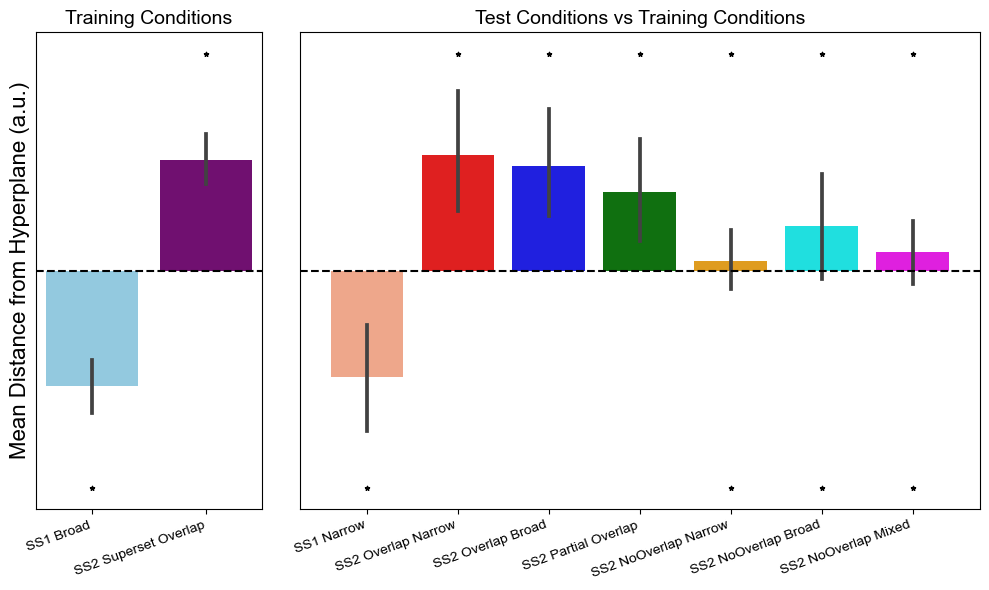

In [ ]:
delay_distances = get_delay_distances(mean_scores, interp, hyperplane_conds)
plot_and_test_mean_delays(delay_distances, figname='DistanceFromHyperplane_barplot.svg')

## First half of delay period

AGAINST 0:
SS1 Broad
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.495499   22   two-sided  2.146049e-08  [-0.95, -0.58]  1.771434   

             BF10  power  
T-test  6.277e+05    1.0  
SS2 Superset Overlap
               T  dof alternative         p-val         CI95%   cohen-d  \
T-test  8.133162   22   two-sided  4.483303e-08  [0.56, 0.94]  1.695882   

             BF10  power  
T-test  3.163e+05    1.0  
DIFFERENT FROM SS1BROAD:
    Contrast          A           B  Paired  Parametric         T   dof  \
0  Condition  SS1 Broad  SS1 Narrow    True        True -0.366015  22.0   

  alternative    p-unc   BF10     cohen  
0   two-sided  0.71785  0.232 -0.088931  
    Contrast          A                   B  Paired  Parametric         T  \
0  Condition  SS1 Broad  SS2 Overlap Narrow    True        True -4.801566   

    dof alternative     p-unc     BF10     cohen  
0  22.0   two-sided  0.000085  314.349 -1.573485  
    Contrast          A    

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests 

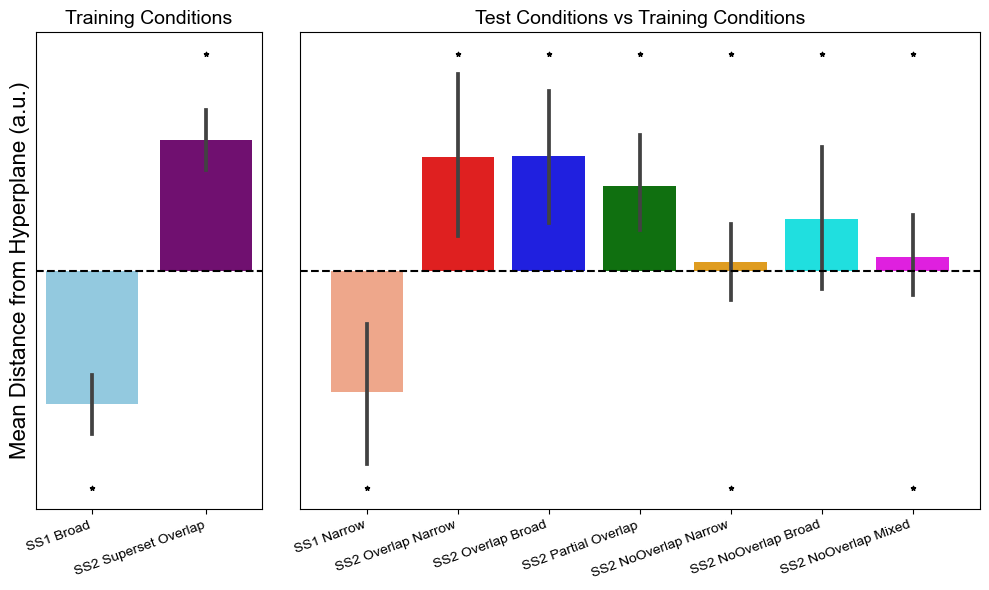

In [ ]:
delay_distances = get_delay_distances(mean_scores, interp, hyperplane_conds, delay_start=250, delay_end=700)
plot_and_test_mean_delays(delay_distances, figname='DistanceFromHyperplane_barplot_firstHalf.svg')

## second half of the delay period

AGAINST 0:
SS1 Broad
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -6.338372   22   two-sided  0.000002  [-0.74, -0.38]  1.321642   

           BF10     power  
T-test  8585.98  0.999978  
SS2 Superset Overlap
              T  dof alternative     p-val         CI95%   cohen-d      BF10  \
T-test  5.87533   22   two-sided  0.000007  [0.34, 0.72]  1.225091  3217.254   

           power  
T-test  0.999866  
DIFFERENT FROM SS1BROAD:
    Contrast          A           B  Paired  Parametric         T   dof  \
0  Condition  SS1 Broad  SS1 Narrow    True        True -0.309474  22.0   

  alternative     p-unc   BF10    cohen  
0   two-sided  0.759873  0.228 -0.06572  
    Contrast          A                   B  Paired  Parametric         T  \
0  Condition  SS1 Broad  SS2 Overlap Narrow    True        True -5.190363   

    dof alternative     p-unc    BF10     cohen  
0  22.0   two-sided  0.000033  733.41 -1.701399  
    Contrast          A                  

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests 

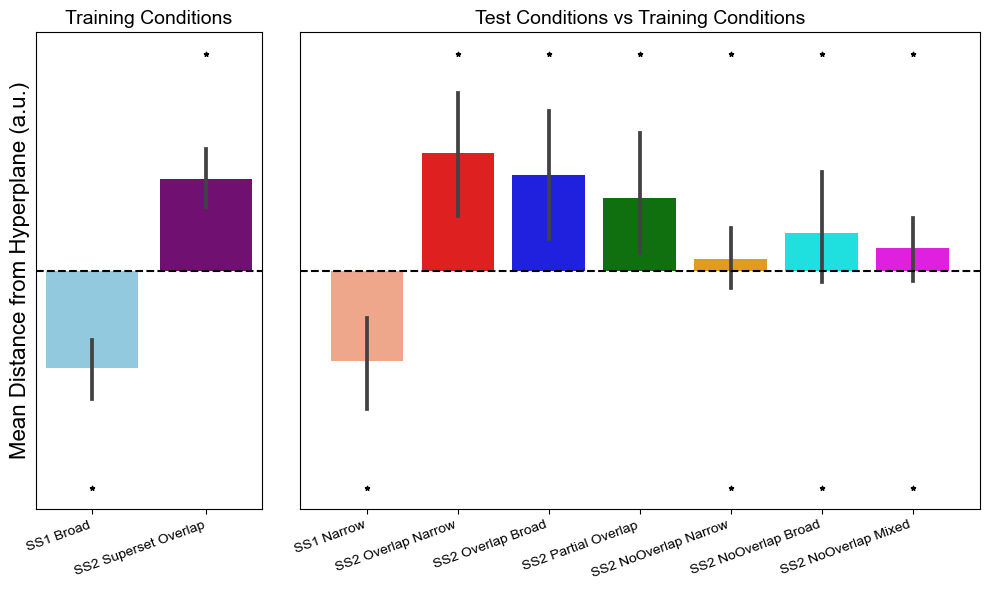

In [ ]:
delay_distances = get_delay_distances(mean_scores, interp, hyperplane_conds, delay_start=700)
plot_and_test_mean_delays(delay_distances, figname='DistanceFromHyperplane_barplot_firstHalf.svg')

# Remove subjects with informative eye movements

In [ ]:
bad_eyes = pd.read_csv('informative_eye_subs.csv', index_col=0).index.values
mean_scores_NBE = np.delete(mean_scores, bad_eyes, axis=0)  # NBE = no bad eyes
mean_scores_NBE.shape

(19, 62, 9)

AGAINST 0:
SS1 Broad
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -7.461501   18   two-sided  6.515492e-07  [-0.79, -0.45]  1.711786   

             BF10  power  
T-test  2.646e+04    1.0  
SS2 Superset Overlap
               T  dof alternative     p-val         CI95%   cohen-d      BF10  \
T-test  6.801848   18   two-sided  0.000002  [0.41, 0.78]  1.560451  8450.362   

           power  
T-test  0.999996  
DIFFERENT FROM SS1BROAD:
    Contrast          A           B  Paired  Parametric         T   dof  \
0  Condition  SS1 Broad  SS1 Narrow    True        True -0.327398  18.0   

  alternative     p-unc   BF10     cohen  
0   two-sided  0.747144  0.249 -0.086294  
    Contrast          A                   B  Paired  Parametric         T  \
0  Condition  SS1 Broad  SS2 Overlap Narrow    True        True -4.582557   

    dof alternative     p-unc     BF10     cohen  
0  18.0   two-sided  0.000231  133.437 -1.746954  
    Contrast          A      

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests 

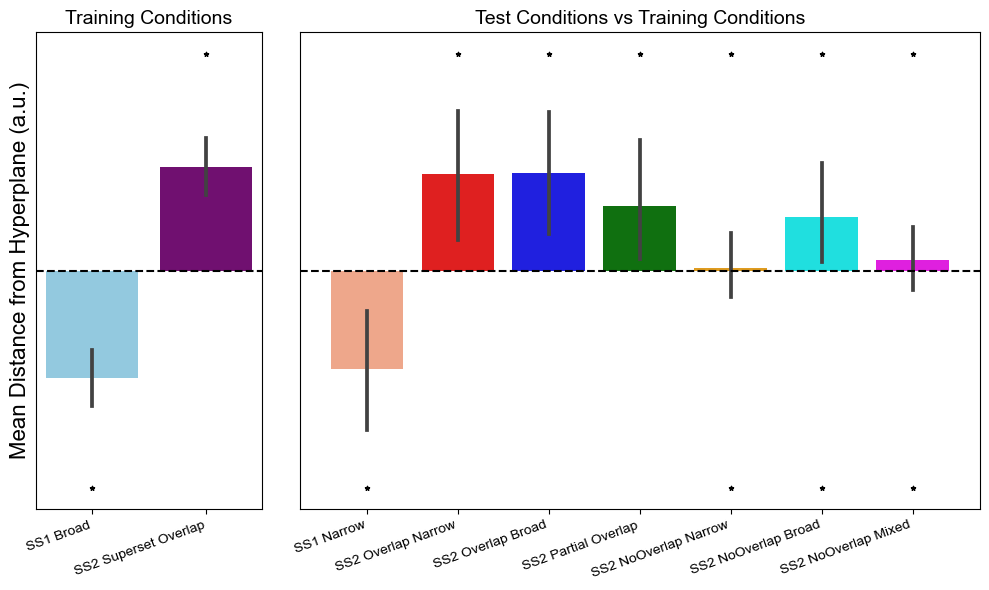

In [ ]:
delay_distances = get_delay_distances(mean_scores_NBE, interp, hyperplane_conds)
plot_and_test_mean_delays(delay_distances, figname='DistanceFromHyperplane_barplot_noInformativeEyes.svg')

AGAINST 0:
SS1 Broad
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -7.187471   18   two-sided  0.000001  [-0.92, -0.51]  1.648919   

             BF10     power  
T-test  1.657e+04  0.999999  
SS2 Superset Overlap
               T  dof alternative     p-val         CI95%   cohen-d      BF10  \
T-test  6.719051   18   two-sided  0.000003  [0.48, 0.92]  1.541456  7297.799   

           power  
T-test  0.999994  
DIFFERENT FROM SS1BROAD:
    Contrast          A           B  Paired  Parametric        T   dof  \
0  Condition  SS1 Broad  SS1 Narrow    True        True -0.30173  18.0   

  alternative     p-unc   BF10    cohen  
0   two-sided  0.766316  0.247 -0.08469  
    Contrast          A                   B  Paired  Parametric         T  \
0  Condition  SS1 Broad  SS2 Overlap Narrow    True        True -3.936159   

    dof alternative     p-unc    BF10   cohen  
0  18.0   two-sided  0.000968  38.028 -1.4305  
    Contrast          A                  

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests 

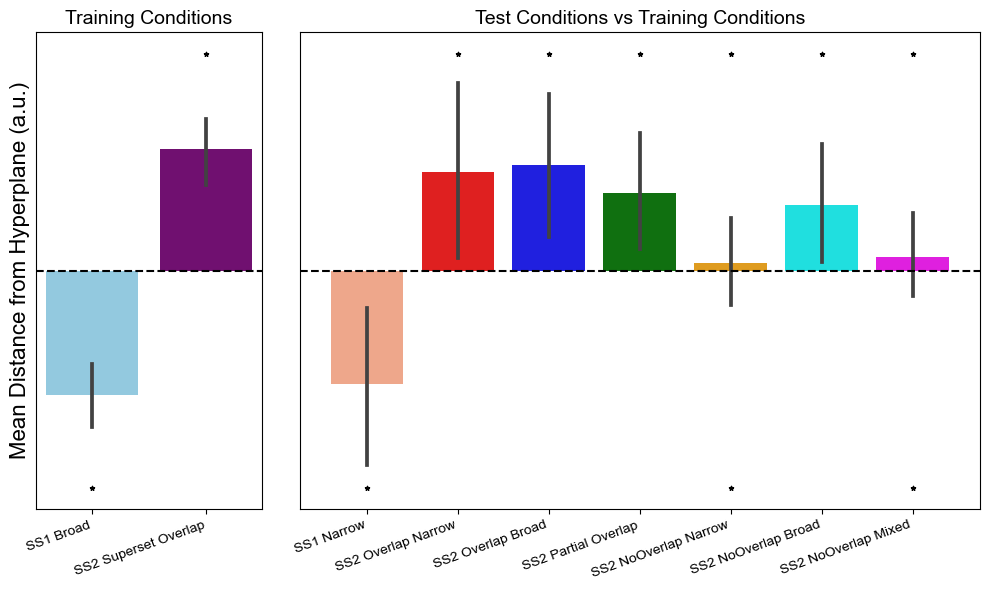

In [ ]:
delay_distances = get_delay_distances(mean_scores_NBE, interp, hyperplane_conds, delay_start=250, delay_end=700)
plot_and_test_mean_delays(delay_distances, figname='DistanceFromHyperplane_barplot_firstHalf_noInformativeEyes.svg')

AGAINST 0:
SS1 Broad
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -5.506668   18   two-sided  0.000031  [-0.72, -0.32]  1.263316   

           BF10     power  
T-test  787.486  0.999391  
SS2 Superset Overlap
               T  dof alternative     p-val         CI95%   cohen-d     BF10  \
T-test  4.933583   18   two-sided  0.000107  [0.29, 0.71]  1.131842  263.282   

           power  
T-test  0.996497  
DIFFERENT FROM SS1BROAD:
    Contrast          A           B  Paired  Parametric         T   dof  \
0  Condition  SS1 Broad  SS1 Narrow    True        True -0.303439  18.0   

  alternative     p-unc   BF10     cohen  
0   two-sided  0.765034  0.248 -0.074173  
    Contrast          A                   B  Paired  Parametric         T  \
0  Condition  SS1 Broad  SS2 Overlap Narrow    True        True -3.993445   

    dof alternative     p-unc    BF10     cohen  
0  18.0   two-sided  0.000852  42.489 -1.422943  
    Contrast          A                

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests 

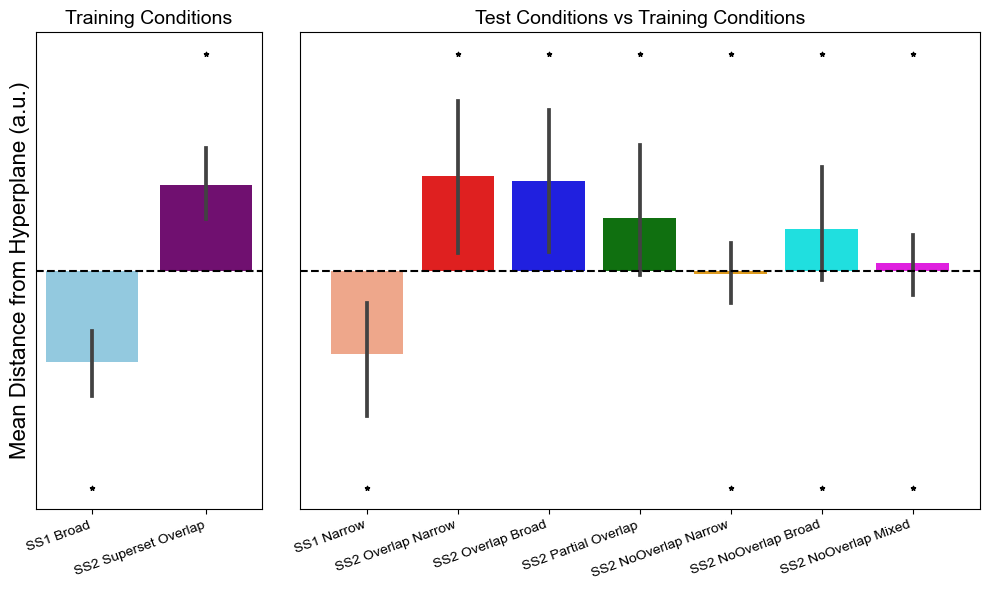

In [ ]:
delay_distances = get_delay_distances(mean_scores_NBE, interp, hyperplane_conds, delay_start=700)
plot_and_test_mean_delays(delay_distances, figname='DistanceFromHyperplane_barplot_lastHalf_noInformativeEyes.svg')